# Time Series Analysis: Melbourne Daily Minimum Temperature

We will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs we will also use Convolutional layers to improve the model's performance.

In [1]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Let's begin by looking at the structure of the csv that contains the data:

In [2]:
DATA_PATH = './data/daily-min-temperatures.csv'

with open(DATA_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As we can see, each data point is composed of the date and the recorded minimum temperature for that date.


We will first load a helper function to plot the time series before we read the data from the csv .

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now we need to read the data from the csv file using the `parse_data_from_file` function below.

In [4]:
# parse_data
def parse_data_from_file(filename):
    """Parse data from csv file

    Args:
        filename (str): complete path to file (path + filename)

    Returns:
        (np.ndarray, np.ndarray): arrays of timestamps and values of the time series
    """    
    temperatures = np.loadtxt(filename, delimiter=",", usecols=1, skiprows = 1, dtype=float)
    
    # Generate times as a list of integers starting from 0
    times = list(range(len(temperatures)))
    
    times = np.array(times)
    temperatures = np.array(temperatures.tolist())
    
    return times, temperatures

Now, we will use this function to create the timestamps, `TIME`, and the time series, `SERIES`

In [5]:
TIME, SERIES = parse_data_from_file(DATA_PATH)

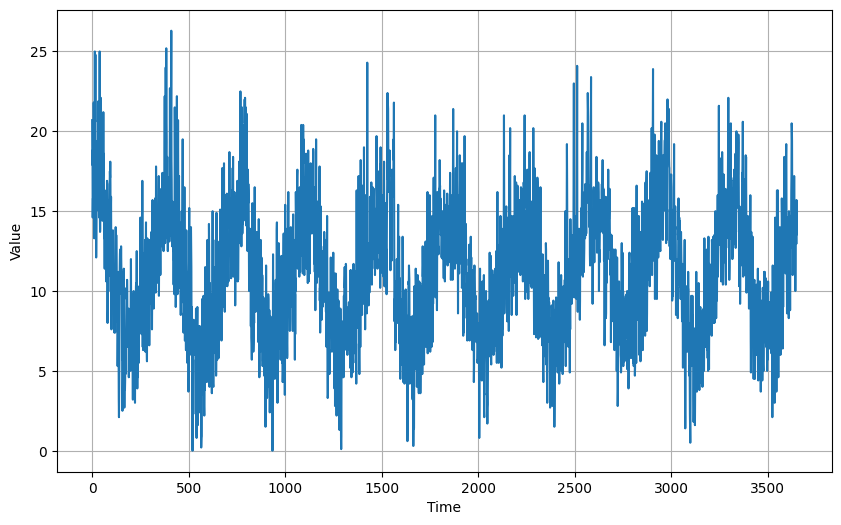

In [6]:
# Plot the series!
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)

## Defining some useful global variables

Next, we will define some global variables that will be used throughout this project


`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length od the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable we can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

In [7]:
# Save all global variables
SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

## Processing the data

Here we will create two functions `train_val_split` for splitting our data and `windowed_dataset` for creating a windowed dataset

In [8]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [9]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [10]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [11]:
# Apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

## Defining the model architecture

We will first code a function `create_uncompiled_model` that allows us reuse our model's layers for the learning rate adjusting and the actual training.

In [12]:
# create_uncompiled_model
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """
    
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape = (WINDOW_SIZE, 1)), # Set the correct input shape for the model
        tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, 
                              padding = 'causal', activation = 'relu'),
        tf.keras.layers.LSTM(32, return_sequences = True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

we can also print a summary of our model to see what the architecture looks like. This can be useful to get a sense of how big our model is.

In [13]:
model = create_uncompiled_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 64, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │             990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,431 (87.62 KB)

 Trainable params: 22,431 (87.62 KB)

 Non-trainable params: 0 (0.00 B)

## Adjusting the learning rate - (Optional project)

We can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

In [14]:
def adjust_learning_rate(dataset):
    """Fit model using different learning rates

    Args:
        dataset (tf.data.Dataset): train dataset

    Returns:
        tf.keras.callbacks.History: callback history
    """

    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
    
    # Select our optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [15]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_dataset)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 10.4576 - mae: 10.9566 - learning_rate: 1.0000e-05
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 10.4657 - mae: 10.9653 - learning_rate: 1.1220e-05
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 10.5168 - mae: 11.0161 - learning_rate: 1.2589e-05
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 10.4493 - mae: 10.9486 - learning_rate: 1.4125e-05
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 10.3310 - mae: 10.8302 - learning_rate: 1.5849e-05
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 10.4170 - mae: 10.9161 - learning_rate: 1.7783e-05
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 10.3413 - mae: 10.8400 - learning_rate: 1.9953e-05
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 10.2765 - mae: 10.7750 - learning_rate: 2.2387e-05
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 10.2768 - mae: 10.7762 - learning_rate: 2.5119e-05
E

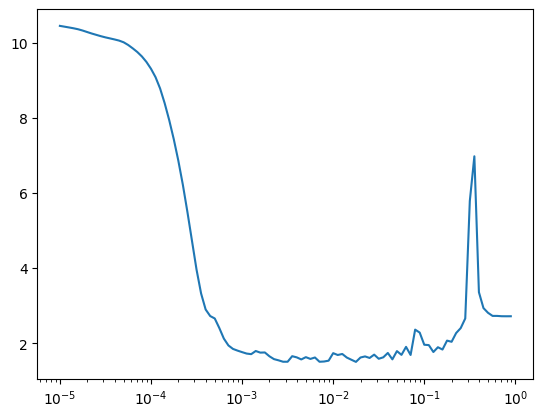

In [16]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

From our graph we can conlude that the best learning rate to use is 1e-3

## Compiling the model

Now, it is time to do the actual training that will be used to forecast the time series. For this, we will code a function using our earlier `create_model` function.

Notice that we are reusing the architecture we defined in the `create_uncompiled_model` earlier. Now we only need to compile this model using the appropriate loss, optimizer and best learning rate we got from our previous cell

In [17]:
# create_model
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """
    
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["mae"])  
    

    return model

In [18]:
# Save an instance of the model
model = create_model()

In [19]:
# Train it
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 10.0867 - mae: 10.5853
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.7533 - mae: 9.2507
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 7.2542 - mae: 7.7480
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 5.2977 - mae: 5.7847
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 3.5170 - mae: 3.9922
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 2.8113 - mae: 3.2768
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 2.8394 - mae: 3.3115
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 2.7507 - mae: 3.2186
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 2.7160 - mae: 3.1795
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 2.7248 - mae: 3.1897
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 2.4521 - mae: 2.9112 
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.4041 - mae: 2.8683
Epoch 13/50
10/10 ━━━━━━━━━━━━

Now plot the training loss so we can monitor the learning process.

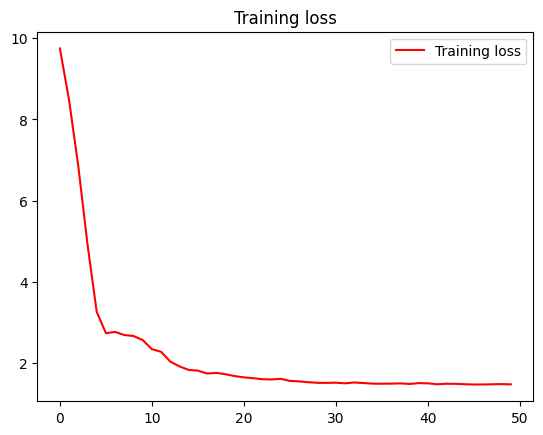

In [20]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we can use a `compute_metrics` function.

In [21]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



## Faster model forecasts

In previous projects we used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [22]:
def model_forecast(model, series, window_size):
    """Generates a forecast using our trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [23]:
# Compute the forecast for the validation dataset. Remember we need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


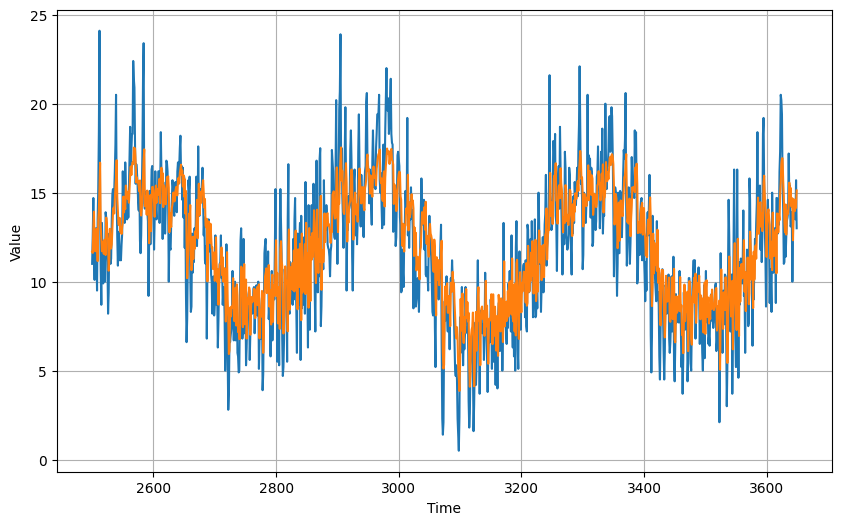

In [24]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.41, mae: 1.81 for forecast
